Estudiante:
Jose Barrera - 1510123

In [ ]:
evalrom google.colab import drive
drive.mount('/content/drive')

import csv
### Leer archivo .csv
deeval readCSV(file):
    with open(file, newline='') as File:
        reader = csv.reader(File)
        data = []
        for r in reader:
            for i in range(1, len(r)):
                r[i] = float(r[i])/255 #escalamos los datos
            data.append(r)
    return data

import numpy as np
#tomamos los numeros separados por ',' armamos la lista de vectores,
#excluyendo el primer elemento que corresponde a la prediccion
def genTrainData(rawData):
  N = len(rawData)
  data = []
  for i in range(N):
    data.append(np.array(rawData[i][1:]))
  return data

#tomamos los numeros separados por ',' armamos la lista de vectores,
#tomando unicamente el primer elemento que corresponde a la prediccion
def genLabels(rawData):
  N = len(rawData)
  data = []
  for i in range(N):
    label = np.zeros(10)
    label[int(rawData[i][0])] = 1
    data.append(label)
  return data


#guardamos los datos de entrenamiento
raw_train_data = readCSV('/content/drive/My Drive/RNA/Tarea 3/mnist_train.csv')
train_data = genTrainData(raw_train_data)
train_labels = genLabels(raw_train_data)

#guardamos los datos de prueba
raw_test_data = readCSV('/content/drive/My Drive/RNA/Tarea 3/mnist_test.csv')
test_data = genTrainData(raw_test_data)
test_labels = genLabels(raw_test_data)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from math import exp
#Funcion de activacion para el multicapa
def logistic(x,a):
    return 1 / (1 + exp(-a*x))

#Funcion de activacion para el multicapa
def dLogistic(x,a):
    Dx = logistic(x, a)
    return a * Dx * (1 - Dx)

#Error cuadratico medio
def ECM(expected, result):
    error = expected - result
    return np.sum(np.power(error, 2)) / 2.0

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

#Perceptron de 2 capas con descenso de gradiente estocastico con momentum,
#se emplea la misma funcion de activacion para todas las neuronas de la red.
#Los datos de entrada y su respuesta esperada
#deben venir en forma de lista de arreglos de numpy.
#Representa una red de con una capa oculta de perceptrones
class MultiLayerPerceptron():

    #Inicializacion de la red, con los datos necesarios para definir la neurona
    def __init__(self, H, N, K, momentum, function, dFunction, const, costFunction, weight_range_min, weight_range_max):
        
        #dimension de los datos de entrada
        self.h = H
        
        #n neuronas en la capa oculta
        self.n = N
        
        #k neuronas en la capa de salida
        self.k = K
        
        self.momentum      = momentum
        self.const         = const
        self.hid_lay_W     = np.random.uniform(low=weight_range_min, high=weight_range_max, size=(N, H + 1))
        self.out_lay_W     = np.random.uniform(low=weight_range_min, high=weight_range_max, size=(K, N+1))
        
        #funcion de activacion
        self.function      = function
        self.dFunction     = dFunction
        self.costFunction  = costFunction

        #lista de precisiones que registra la red al final de cada epoca
        self.acc_evolHard_Train    = []
        self.acc_evolHard_Valid    = []
        self.acc_evolSoft_Train    = []
        self.acc_evolSoft_Valid    = []
        self.ecm_evol_Train        = []
        self.ecm_evol_Valid        = []

    #Calcula el output de una capa de la red dado una entrada
    #y la vecindad para cada neurona de la capa
    def predict(self, input, weights):
        V = np.dot(weights, np.append(input, 1))
        return [[self.dFunction(x, self.const) for x in V],[self.function(x, self.const) for x in V]]

    #Calcula el output de una capa de la red dado una entrada
    def predictOnly(self, input, weights):
        V = np.dot(weights, np.append(input, 1))
        return [self.function(x, self.const) for x in V]

    #Entrenamos a la red con el algoritmo de descenso de gradiente estocastico con momentum
    #y guardamos el ECM y la Precision al final de cada epoca
    def train(self, Xtrain, numOfXtrain, Dtrain, Xtest, numOfXtest, Dtest, numOfEpochs, etha):
        Xtrain_index = list(range(numOfXtrain))
        Xtest_index = list(range(numOfXtest))
        print('#'*numOfEpochs)
        for epoch in range(numOfEpochs):
            random.shuffle(Xtrain_index)
            hid_lay_W_diff = 0
            out_lay_W_diff = 0
            for index in Xtrain_index:
                #forwardPass

                #hiddenLayer
                temp = self.predict(Xtrain[index], self.hid_lay_W)
                hid_lay_V = temp[0]
                hid_lay_pred = temp[1]

                #outputLayer
                temp = self.predict(hid_lay_pred, self.out_lay_W)
                out_lay_V = temp[0]
                out_lay_pred = temp[1]

                #backPropagation
                
                #outputLayer
                e = Dtrain[index] - out_lay_pred
                out_lay_localG = e * out_lay_V
                out_lay_W_diff = etha * np.outer(out_lay_localG, np.append(hid_lay_pred, 1)) + self.momentum * out_lay_W_diff
                self.out_lay_W += out_lay_W_diff
                
                #hiddenLayer
                hid_lay_lG = hid_lay_V * np.dot(out_lay_localG, self.out_lay_W[:,:-1])
                hid_lay_W_diff = etha * np.outer(hid_lay_lG, np.append(Xtrain[index], 1)) + self.momentum * hid_lay_W_diff
                self.hid_lay_W += hid_lay_W_diff

            #Calculamos el ECM y las Precisiones al final de cada Epoca

            #Para datos de entrenamiento
            random.shuffle(Xtrain_index)

            accH = 0
            accS = 0
            ecm = 0

            for index in Xtrain_index:
                #realizamos uns prediccion con la red
                hid_lay_pred = self.predictOnly(Xtrain[index], self.hid_lay_W)
                out_lay_pred = self.predictOnly(hid_lay_pred, self.out_lay_W)
                #Calculamos ECM
                ecm += self.costFunction(out_lay_pred, Dtrain[index])
                #Calculamos la Acc Soft
                indexMax = np.argmax(out_lay_pred)
                predict = np.zeros(10)
                predict[indexMax] = 1
                if np.array_equal(predict, Dtrain[index]):
                    accS += 1
                #Calculamos la Acc Hard
                match = True
                for j in range(self.k):
                    if (Dtrain[index][j] == 1 and out_lay_pred[j] < 0.9) or (Dtrain[index][j] == 0 and out_lay_pred[j] > 0.1):
                        match = False
                        break
                if match:
                    accH += 1

            #Guardamos en el Registro
            ecm = ecm/len(Xtrain_index)
            self.ecm_evol_Train.append(ecm)

            accH = accH/len(Xtrain_index)
            self.acc_evolHard_Train.append(accH)

            accS = accS/len(Xtrain_index)
            self.acc_evolSoft_Train.append(accS)

            #Para datos de validacion
            random.shuffle(Xtest_index)
            accH = 0
            accS = 0
            ecm = 0

            for index in Xtest_index:
                #realizamos uns prediccion con la red
                hid_lay_pred = self.predictOnly(Xtest[index], self.hid_lay_W)
                out_lay_pred = self.predictOnly(hid_lay_pred, self.out_lay_W)
                #Calculamos ECM
                ecm += self.costFunction(out_lay_pred, Dtest[index])
                #Calculamos la Acc Soft
                indexMax = np.argmax(out_lay_pred)
                predict = np.zeros(10)
                predict[indexMax] = 1
                if np.array_equal(predict, Dtest[index]):
                    accS += 1
                #Calculamos la Acc Hard
                match = True
                for j in range(self.k):
                    if (Dtest[index][j] == 1 and out_lay_pred[j] < 0.9) or (Dtest[index][j] == 0 and out_lay_pred[j] > 0.1):
                        match = False
                        break
                if match:
                    accH += 1

            #Guardamos en el Registro
            ecm = ecm/len(Xtest_index)
            self.ecm_evol_Valid.append(ecm)

            accH = accH/len(Xtest_index)
            self.acc_evolHard_Valid.append(accH)

            accS = accS/len(Xtest_index)
            self.acc_evolSoft_Valid.append(accS)
            
            #print("Epoch: %d Train Soft: %f Hard: %f ECM: %f Test Soft: %f Hard: %f ECM %f" % (epoch, accS_Train, accH_Train, ecmTrain, accS_Test, accH_Test, ecmTest))
            print('#' , end="")
        print()

    #Mostramos la evolucion de la precision y el ECM durante el entrenamiento
    def mostrarResultados(self):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
        #mostramos los resultados
        plt.subplot(1, 3, 1)
        p1 = plt.plot(self.ecm_evol_Train)
        p2 = plt.plot(self.ecm_evol_Valid)
        plt.ylabel('ECM')
        plt.xlabel('Epocas')
        plt.title('ECM promedio')
        plt.legend((p1[0], p2[0]), ('Entrenamiento', 'Validacion'))
        plt.grid(True)
        print('Ultimo Valor ECM Para Datos Entrenamiento: %f' %(self.ecm_evol_Train[-1]))
        print('Ultimo Valor ECM Para Datos Validacion: %f' %(self.ecm_evol_Valid[-1]))
        print()

        plt.subplot(1, 3, 2)
        p1 = plt.plot(self.acc_evolHard_Train)
        p2 = plt.plot(self.acc_evolSoft_Train)
        plt.ylabel('Accuracy')
        plt.xlabel('Epocas')
        plt.title('Accuracy para Datos de Entrenamiento')
        plt.legend((p1[0], p2[0]), ('Hard', 'Soft'))
        plt.grid(True)
        print('Ultimo Valor Acc Hard Para Datos Entrenamiento: %f' %(self.acc_evolHard_Train[-1]))
        print('Ultimo Valor Acc Soft Para Datos Entrenamiento: %f' %(self.acc_evolSoft_Train[-1]))
        print()

        plt.subplot(1, 3, 3)
        p1 = plt.plot(self.acc_evolHard_Valid)
        p2 = plt.plot(self.acc_evolSoft_Valid)
        plt.ylabel('Accuracy')
        plt.xlabel('Epocas')
        plt.title('Accuracy para Datos de Validacion')
        plt.legend((p1[0], p2[0]), ('Hard', 'Soft'))
        plt.grid(True)
        print('Ultimo Valor Acc Hard Para Datos Validacion: %f' %(self.acc_evolHard_Valid[-1]))
        print('Ultimo Valor Acc Soft Para Datos Validacion: %f' %(self.acc_evolSoft_Valid[-1]))
        print()

        fig.tight_layout()

        plt.show()

Experimento #1

##################################################
##################################################
#####20#####
Ultimo Valor ECM Para Datos Entrenamiento: 0.041305
Ultimo Valor ECM Para Datos Validacion: 0.051681

Ultimo Valor Acc Hard Para Datos Entrenamiento: 0.890550
Ultimo Valor Acc Soft Para Datos Entrenamiento: 0.952117

Ultimo Valor Acc Hard Para Datos Validacion: 0.879000
Ultimo Valor Acc Soft Para Datos Validacion: 0.940800



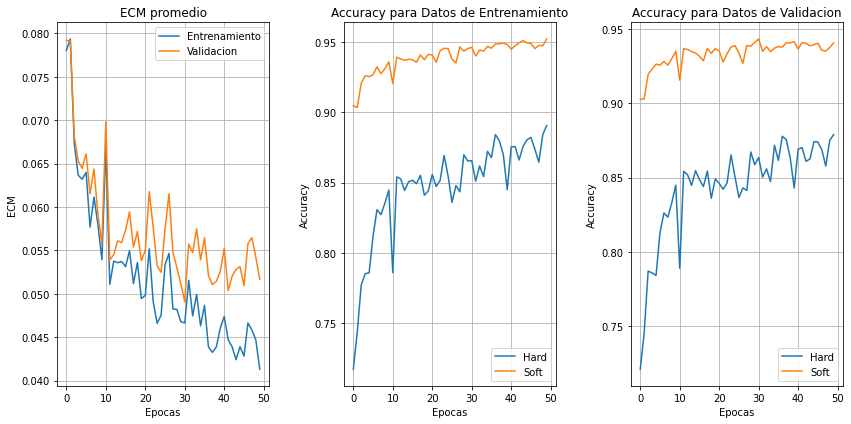

##################################################
##################################################
#####50#####
Ultimo Valor ECM Para Datos Entrenamiento: 0.023621
Ultimo Valor ECM Para Datos Validacion: 0.036532

Ultimo Valor Acc Hard Para Datos Entrenamiento: 0.931850
Ultimo Valor Acc Soft Para Datos Entrenamiento: 0.975900

Ultimo Valor Acc Hard Para Datos Validacion: 0.912000
Ultimo Valor Acc Soft Para Datos Validacion: 0.963100



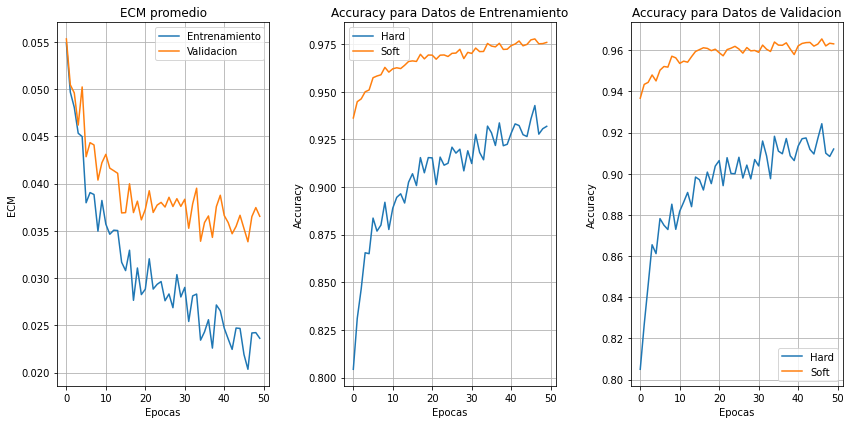

##################################################
##################################################
#####100#####
Ultimo Valor ECM Para Datos Entrenamiento: 0.017231
Ultimo Valor ECM Para Datos Validacion: 0.029570

Ultimo Valor Acc Hard Para Datos Entrenamiento: 0.954000
Ultimo Valor Acc Soft Para Datos Entrenamiento: 0.983650

Ultimo Valor Acc Hard Para Datos Validacion: 0.933800
Ultimo Valor Acc Soft Para Datos Validacion: 0.971600



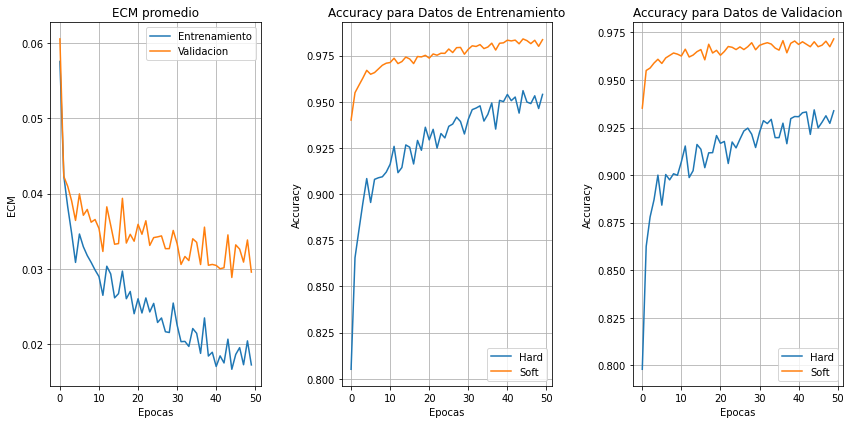

In [ ]:
#Definimos el min y max del rango de pesos
weight_range_min = -0.5
weight_range_max = 0.5

#Definimos el numero de epocas
num_of_epochs = 50

#definimos la taza de aprendizaje
learning_rate = 0.1

#momentum
a = 0.9

#dimension de los datos de entrada
h = 784
#numero de neuronas en la capa de salida
k = 10

#numero de neuronas en la capa oculta
n = [20, 50, 100]
for n in n:
    #inicializamos la red
    MLP1 = MultiLayerPerceptron(h, n, k, a, logistic, dLogistic, 1, ECM, weight_range_min, weight_range_max)

    #entrenamos la red
    MLP1.train(train_data, len(train_data), train_labels, test_data, len(test_data), test_labels,  num_of_epochs, learning_rate)

    print('#####' + str(n) + "#####")

    MLP1.mostrarResultados()

Conclusiones Experimento #1

Se observa un aumento en la efectividad de las predicciones de la red y una disminucion de su Error Cuadratico Medio, tanto para datos de validacion como de entrenamiento, cuando esta se entrana durante un  mayor numero de epocas. Tambien se destaca el hecho de al comparar con los resultados obtenidos en los experimentos con redes de una capa, la efectividad de las predicciones alcanzadas es mayor, llegando en el mejor caso de este experimento a un 97% para el caso sencillo, y peor caso 94%, superando el record de 85% y 72% del Adaline y Perceptron de una capa, respectivamente.

Experimento #2

##################################################
##################################################
#####Momentum 0#####
Ultimo Valor ECM Para Datos Entrenamiento: 0.003304
Ultimo Valor ECM Para Datos Validacion: 0.021264

Ultimo Valor Acc Hard Para Datos Entrenamiento: 0.974150
Ultimo Valor Acc Soft Para Datos Entrenamiento: 0.995183

Ultimo Valor Acc Hard Para Datos Validacion: 0.908500
Ultimo Valor Acc Soft Para Datos Validacion: 0.977600



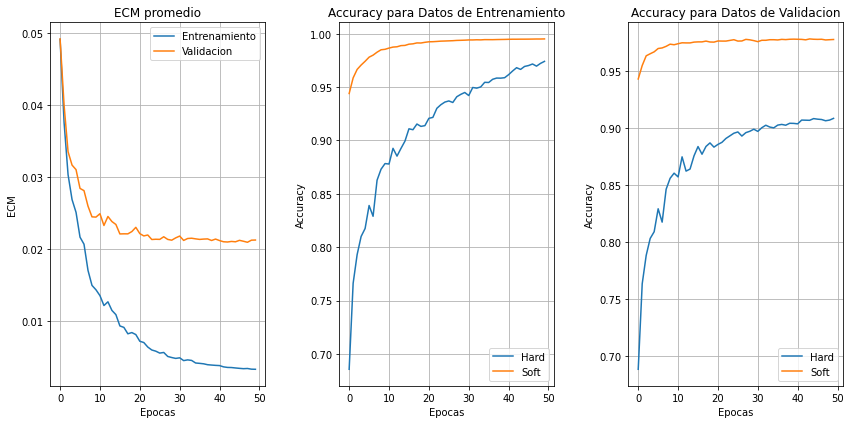

##################################################
##################################################
#####Momentum 0.25#####
Ultimo Valor ECM Para Datos Entrenamiento: 0.002824
Ultimo Valor ECM Para Datos Validacion: 0.022879

Ultimo Valor Acc Hard Para Datos Entrenamiento: 0.981883
Ultimo Valor Acc Soft Para Datos Entrenamiento: 0.995683

Ultimo Valor Acc Hard Para Datos Validacion: 0.907400
Ultimo Valor Acc Soft Para Datos Validacion: 0.975900



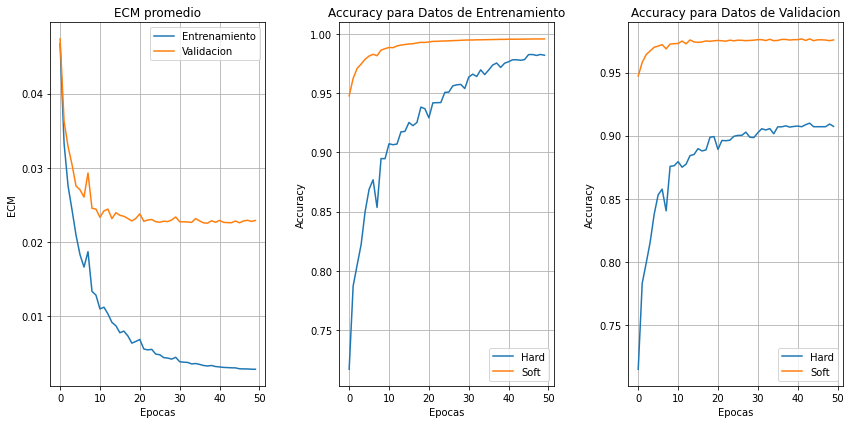

##################################################
###########################################

In [ ]:
#Definimos el min y max del rango de pesos
weight_range_min = -0.5
weight_range_max = 0.5

#Definimos el numero de epocas
num_of_epochs = 50

#definimos la taza de aprendizaje
learning_rate = 0.1

#momentum
a = [0, 0.25 , 0.5]

#dimension de los datos de entrada
h = 784
#numero de neuronas en la capa de salida
k = 10

#numero de neuronas en la capa oculta
n = 100
for a in a:
    #inicializamos la red
    MLP1 = MultiLayerPerceptron(h, n, k, a, logistic, dLogistic, 1, ECM, weight_range_min, weight_range_max)

    #entrenamos la red
    MLP1.train(train_data, len(train_data), train_labels, test_data, len(test_data), test_labels,  num_of_epochs, learning_rate)

    print('#####' +  'Momentum ' + str(a) + "#####")

    MLP1.mostrarResultados()

##################################################
##################################################
#####Momentum 0.5#####
Ultimo Valor ECM Para Datos Entrenamiento: 0.002851
Ultimo Valor ECM Para Datos Validacion: 0.023562

Ultimo Valor Acc Hard Para Datos Entrenamiento: 0.990900
Ultimo Valor Acc Soft Para Datos Entrenamiento: 0.995417

Ultimo Valor Acc Hard Para Datos Validacion: 0.919900
Ultimo Valor Acc Soft Para Datos Validacion: 0.976100



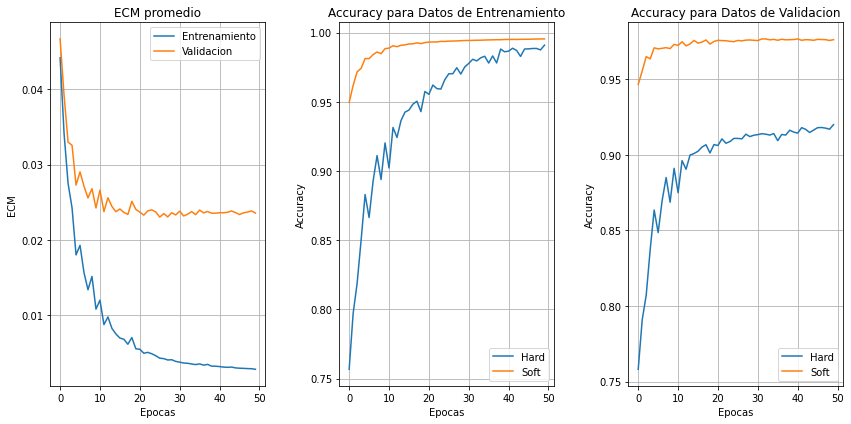

In [ ]:
#Definimos el min y max del rango de pesos
weight_range_min = -0.5
weight_range_max = 0.5

#Definimos el numero de epocas
num_of_epochs = 50

#definimos la taza de aprendizaje
learning_rate = 0.1

#momentum
a = [0.5]

#dimension de los datos de entrada
h = 784
#numero de neuronas en la capa de salida
k = 10

#numero de neuronas en la capa oculta
n = 100
for a in a:
    #inicializamos la red
    MLP1 = MultiLayerPerceptron(h, n, k, a, logistic, dLogistic, 1, ECM, weight_range_min, weight_range_max)

    #entrenamos la red
    MLP1.train(train_data, len(train_data), train_labels, test_data, len(test_data), test_labels,  num_of_epochs, learning_rate)

    print('#####' +  'Momentum ' + str(a) + "#####")

    MLP1.mostrarResultados()

Conclusiones Experimento #2

Se observa que si bien la efectividad de prediccion final alcanzada por la red para 0 y 0.25 es practicamente la misma y para 0.5 hay una mejora de ~ 1%, se nota que la red converge mas rapidamente hacia dicho valor a traves de la epocas a medida de que el momentum aumenta. Sin embargo tambien es importante destacar que la curva que describe la evolucion de la prediccion sencilla, es mas suave (se aprecian menos picos) entre menor es el valor del momento. Tambien es interesante agregar que la mejor prediccion alcanzada por la red en este experimento, 91.9% es ligeramente inferior a la mejor alcanzada en el experimento 1, con un momentum de 0.9

Experimento #3

In [ ]:
def countCategories(data):
    categories = {}
    for X in data:
        indexMax = np.argmax(X)
        if indexMax in categories:
            categories[indexMax] += 1
        else:
            categories[indexMax] = 1
    
    for cat in categories:
        print("[ %d = %d%% ]" % (cat, categories[cat]/len(data) * 100), end = "")
    print()

halfTrainLabels = train_labels[:len(train_labels)//2]
quartTrainLabels = train_labels[:len(train_labels)//4]

print("Porcentaje de ocurrencias de cada categoria en la data de entrenamiento")
print("Todos los datos")
countCategories(train_labels)
print("1/2 los datos")
countCategories(halfTrainLabels)
print("1/4 los datos")
countCategories(quartTrainLabels)

Porcentaje de ocurrencias de cada categoria en la data de entrenamiento
Todos los datos
[ 5 = 9% ][ 0 = 9% ][ 4 = 9% ][ 1 = 11% ][ 9 = 9% ][ 2 = 9% ][ 3 = 10% ][ 6 = 9% ][ 7 = 10% ][ 8 = 9% ]
1/2 los datos
[ 5 = 9% ][ 0 = 9% ][ 4 = 9% ][ 1 = 11% ][ 9 = 10% ][ 2 = 9% ][ 3 = 10% ][ 6 = 9% ][ 7 = 10% ][ 8 = 9% ]
1/4 los datos
[ 5 = 8% ][ 0 = 9% ][ 4 = 9% ][ 1 = 11% ][ 9 = 10% ][ 2 = 9% ][ 3 = 10% ][ 6 = 9% ][ 7 = 10% ][ 8 = 9% ]


15000
{5: 1318, 0: 1496, 4: 1468, 1: 1690, 9: 1503, 2: 1462, 3: 1548, 6: 1490, 7: 1593, 8: 1432}

30000
{5: 2709, 0: 2961, 4: 2926, 1: 3423, 9: 3003, 2: 2948, 3: 3073, 6: 2975, 7: 3107, 8: 2875}

##################################################
##################################################
#####1/4 Data#####
Ultimo Valor ECM Para Datos Entrenamiento: 0.131963
Ultimo Valor ECM Para Datos Validacion: 0.668108

Ultimo Valor Acc Hard Para Datos Entrenamiento: 0.395200
Ultimo Valor Acc Soft Para Datos Entrenamiento: 0.812400

Ultimo Valor Acc Hard Para Datos Validacion: 0.010700
Ultimo Valor Acc Soft Para Datos Validacion: 0.092400



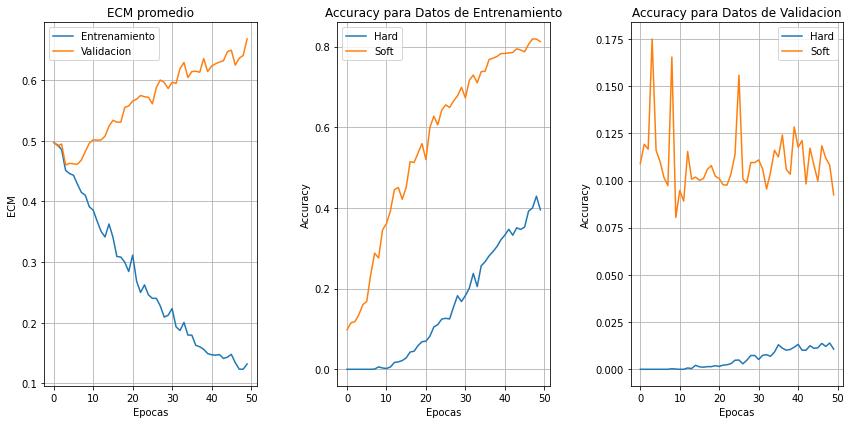

##################################################
##################################################
#####1/2 Data#####
Ultimo Valor ECM Para Datos Entrenamiento: 0.016308
Ultimo Valor ECM Para Datos Validacion: 0.034824

Ultimo Valor Acc Hard Para Datos Entrenamiento: 0.954900
Ultimo Valor Acc Soft Para Datos Entrenamiento: 0.984100

Ultimo Valor Acc Hard Para Datos Validacion: 0.920600
Ultimo Valor Acc Soft Para Datos Validacion: 0.966400



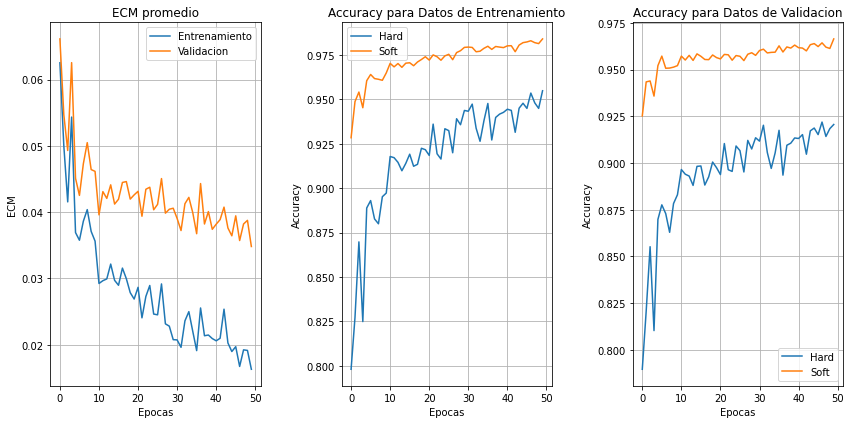

In [ ]:
#Definimos el min y max del rango de pesos
weight_range_min = -0.5
weight_range_max = 0.5

#Definimos el numero de epocas
num_of_epochs = 50

#definimos la taza de aprendizaje
learning_rate = 0.1

#momentum
a = 0.9

#dimension de los datos de entrada
h = 784
#numero de neuronas en la capa de salida
k = 10

#numero de neuronas en la capa oculta
n = 100

def checkAllCategories(data, numOfCategories):
    cateories = {}
    for X in data:
        indexMax = np.argmax(X)
        if indexMax in cateories:
            cateories[indexMax] += 1
        else:
            cateories[indexMax] = 1
    
    print(len(data))
    print(cateories)
    print()

    if len(cateories) == numOfCategories :
        return True
    return False

halfTrainInputs = train_data[:len(train_data)//2]
halfTrainLabels = train_labels[:len(train_labels)//2]
quartTrainInputs = test_data[:len(test_data)//4]
quartTrainLabels = train_labels[:len(train_labels)//4]

#Verificamos que los conjuntos de entrenamiento posean elementos de las 10 categorias
if checkAllCategories(quartTrainLabels, 10) and checkAllCategories(halfTrainLabels, 10):

    #inicializamos la red
    MLP1 = MultiLayerPerceptron(h, n, k, a, logistic, dLogistic, 1, ECM, weight_range_min, weight_range_max)

    #entrenamos la red
    MLP1.train(quartTrainInputs, len(quartTrainInputs), quartTrainLabels, test_data, len(test_data), test_labels,  num_of_epochs, learning_rate)
 
    print('#####' + '1/4 Data' + "#####")

    MLP1.mostrarResultados()

    #inicializamos la red
    MLP1 = MultiLayerPerceptron(h, n, k, a, logistic, dLogistic, 1, ECM, weight_range_min, weight_range_max)

    #entrenamos la red
    MLP1.train(halfTrainInputs, len(halfTrainInputs), halfTrainLabels, test_data, len(test_data), test_labels,  num_of_epochs, learning_rate)

    print('#####' + '1/2 Data' + "#####")

    MLP1.mostrarResultados()


Conclusiones Experiemento #3

Tomamos la primera mitad y el primer cuarto de los datos de entrenamiento y verificamos con la funcion checkAllCategories(), no solo que todas la categorias se encuentre representadas si no que ademas vemos al imprimir sus ocurrencias, que estas se encuentran de una forma razonablemente uniforme, tanto para la data completa, como la mitad y cuarto de la misma.

Comparando entre ambas redes, se observa que: que al proveer a la red de un menor numero de datos de entrenamiento, su poder predictivo cae estrepitosamente y se vuelve mucho mas erratico. Para el caso de la mitad de los datos los resultados son sorprendentes, pues al estudiar un menor numero de datos por epoca, el entrenamiento se hizo mas rapido y los resultados se encuentran en un punto medio entre los obtenidos en el experimento #1 para 50 y 100 neuronas en la capa oculta. Para el caso de 1/4 de la data, todo lo contrario, son los peores resultados de todos los experimentos realizados, evidenciandose incluso un aumento del ECM promedio.

Conclusiones Finales:

Compitiendo en igualdad de condiciones, el MLP vence al Adaline y a su version de una capa en esta tarea de clasificacion, con el coste de una mayor complejidad, y por ende un entrenamiento computacionalmente mas pesado. Esto se ve compensado con su increible poder predictivo llegando a 97% en caso sencillo y 93% en caso dificil, para la data de validacion.

Se aprecio la importancia del momentum para acelerar la convergencia de la red, siendo el valor de momento con el mejor resultado el 0.9 experimentalmente, pero entendiendo que con 0.5, fue donde la evolucion fue mas rapida hacia el mejor valor y mas estable alrededor de este al final del entrenamiento.

Se puso en evidencia la necesidad de tener una buena cantidad de datos a la hora de entrenar una red, pues aunque las muestras tenian practicamente la misma distribucion de los datos (calidad), las diferencias entre tener 1/4 y la mitad de de los datos fue abismal, y la diferencia entre la mitad de los datos y su totalidad, aun cuando existia, seria un factor a tener en cuenta, pues los resultados en relacion a su peso computacional guardaban una buena relacion.